# `Stan` Week!  Lecture 1
![alt text](imgs/stan2.jpg)

## What is Stan?
`Stan` is a probabilistic programming language, named after [Stanislaw Ulam](https://en.wikipedia.org/wiki/Stanislaw_Ulam), one of the fathers of the Monte Carlo method. `Stan` follows in the tradition of previous Bayesian computational tools such as `BUGS` or `JAGS`. Although technically a programming language in its own right (it's Turing complete!) in practice `Stan` is used primarily for Monte Carlo sampling. We will be operating `Stan` from within `R`, using a package called `RStan` (variants exist for `Python` and others).

Before we can dive in to `Stan`, we're going to take a look at the type of MCMC it implements, called Hamilonian Markov Chain Monte Carlo, also called Hybrid Monte Carlo (HMC). When applied properly, HMC can be very efficient relative to the Metropolis-Hastings algorithm that we have previously learned. To be able to use `Stan` effectively, we first need to have some understanding of HMC. This will help us diagnose `Stan`'s error messages, as well as understand what models it can or cannot handle.  

## Hamilonian/Hybrid Monte Carlo
To illustrate HMC, it's useful to first recall the Random-Walk Metropolis-Hastings algorithm (RW-MH). Remember, this algorithm approximates a posterior density, which we'll denote $f(\theta)$. To do so, it generates successive random samples $\theta_k$ using a Markov Chain. The chain is constructed so that it converges to the distribution $f(\theta)$. Thus after sufficient iterations, the $\theta_k$ will be distributed according to $f(\theta)$.   

The simplest version of RW-MH iterates over the following steps:
1. Starting at $\theta_k$, draw a proposal $\theta^* \sim N(\theta_k, \sigma_p^2)$
2. Compute the acceptance probability $\alpha = \min \left(1, \frac{f(\theta^*)}{f(\theta_k)} \right)$ 
3. Set $\theta_{k+1} = \theta^*$ with probability $\alpha$, otherwise $\theta_{k+1}= \theta_k$

This algorithm is simple and flexible, and works well for many densities. Nevertheless in higher dimensional spaces, or for posteriors with unusual structures, it can be inefficient. Let's test it on this arbitrary "banana density", which we'll define over variables $x$ and $y$. We're not going to interpret this as a posterior density, it's just an example to show how the algorithm behaves. 

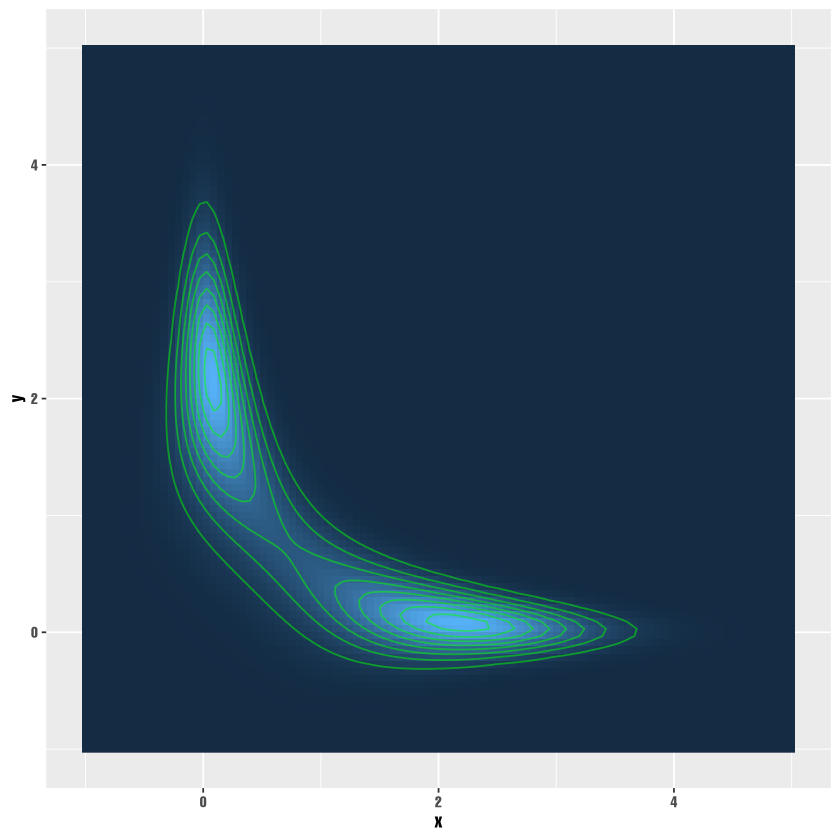

In [1]:
set.seed(8675309)

library(ggplot2)
library(pracma)
library(mvtnorm)
library(coda)
library(MASS)

# Define a two-dimensional density with challenging structure:
banana.density = function(x,y,a,b,c,d){
    exponent = a*x^2*y^2 + x^2 + y^2 + b*x*y - c*(x+y) 
    return( exp(-d*exponent) )
}


# The parameters of our density
# we're not going to try to estimate these
a = 3
b = 1 
c = 4.5
d = 1

# Evaluate density over grid for plotting
grid.size = 1e2
grid.min = -1
grid.max = 5
x.grid = seq(grid.max, grid.min, length.out=grid.size)
y.grid = seq(grid.max, grid.min, length.out=grid.size)
grid = meshgrid(x.grid,y.grid)

x.grid = as.numeric(grid$X)
y.grid = as.numeric(grid$Y)
grid = data.frame(x=x.grid,y=y.grid)

grid$density = apply(grid,1,function(x){
    banana.density(x[1],x[2],a,b,c,d)
})

p = ggplot(grid,aes(x=x,y=y,z=density)) + 
  geom_raster(aes(fill=density)) +
  geom_contour(color='green',alpha=.5) +
    theme(legend.position='None')

p

We see that the banana density is not only curved, but also has two posterior modes. How do you think RW-MH will behave when sampling this density?

Warning message in nlm(function(x) {:
“NA/Inf replaced by maximum positive value”
Warning message:
“Ignoring unknown aesthetics: z”


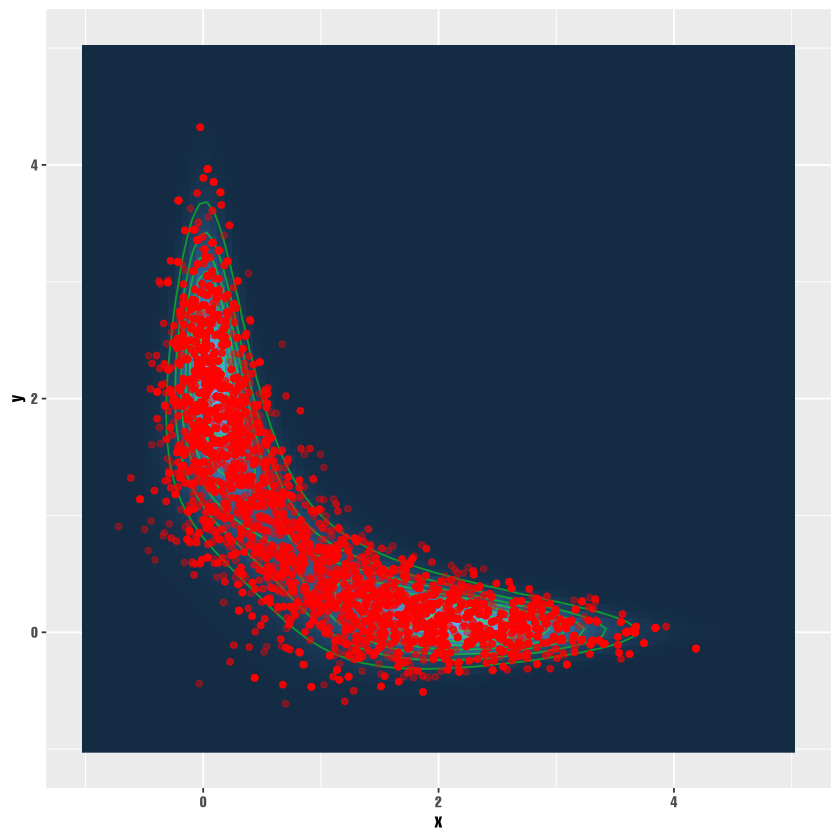

In [2]:
set.seed(8675309)
# implement RW-MH 
RWMH.sampler = function(nsamps,start,posterior,prop.var){
    # args:
    # nsamps - number of sampler iterations
    # start - initial value of the sampler
    # posterior - density we want to sample from
    # prop.var - the variance of the proposal density   
    d = length(start)
    samps = matrix(start,nrow=nsamps,ncol=d,byrow=TRUE)
     
    for (i in 2:nsamps){
        cand = rmvnorm(1,samps[i-1,],prop.var)
        alpha = exp( log(posterior(cand)) - log(posterior(samps[i-1,])) )
        u = runif(1)
        
        if (u<alpha){
            samps[i,] = cand
        }
        
        else {
            samps[i,] = samps[i-1,]
        }
    }
    
    return(data.frame('x'=samps[,1],'y'=samps[,2]))
}  


# run RW-MH over test density
f = function(x){banana.density(x[1],x[2],a,b,c,d)}
start = nlm(function(x){-log(f(x))},c(0,0))$estimate
nsamps = 1e4
mh.samps = RWMH.sampler(nsamps, start, f, diag(2))

# 2D traceplot
p + geom_point(data=mh.samps,aes(x=x,y=y,z=''),color='red',alpha=.4) # 2-D traceplot

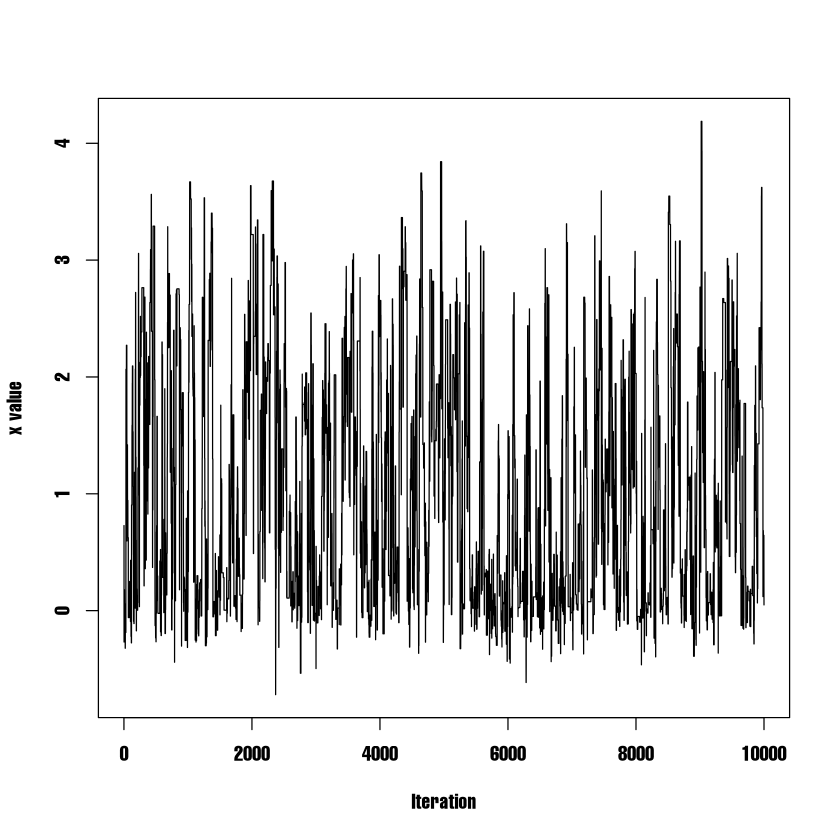

In [3]:
# 1D traceplot
plot(mh.samps$x,type='l',xlab='Iteration',ylab='x value')

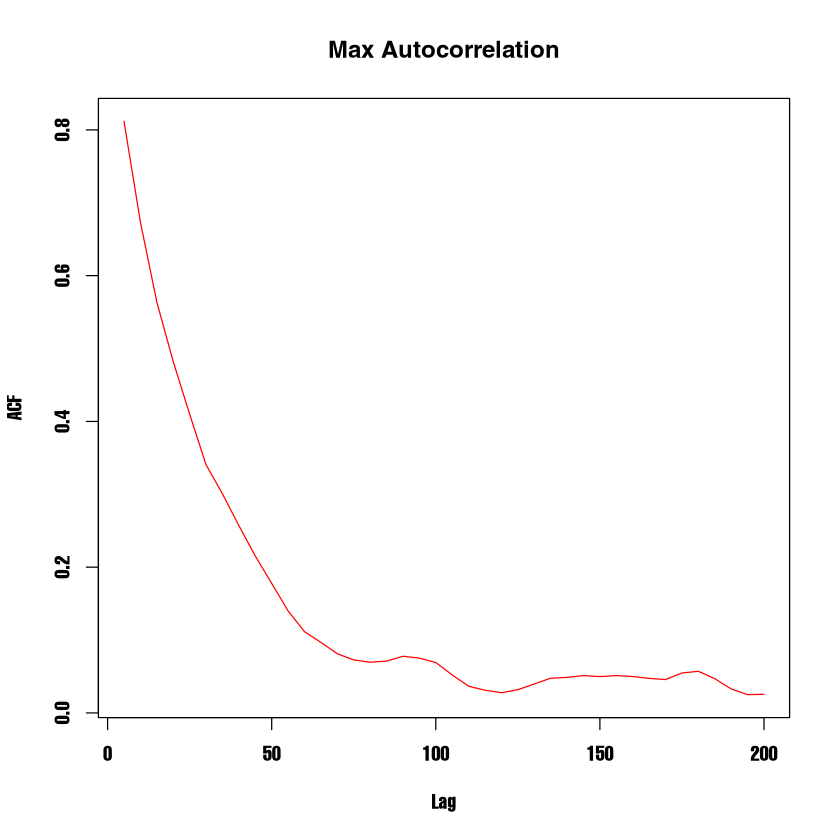

In [4]:
# plot autocorrelation (maxed across x and y)
lags = seq(5,200,5)
mh.acf = apply(autocorr.diag(mcmc(mh.samps),lags=lags), 1, function(x){max(abs(x))})
plot(lags, mh.acf, type='l', xlab='Lag', ylab='ACF', main='Max Autocorrelation',col='red')

As we see, our sample chain has a pretty large amount of autocorrelation, and so our effective sample size is going to be small (reduced by a factor of at least 100). In this case RW-MH is not very *efficient*. But can we do better?  

Actually we can! One of the core problems with our simple RW-MH algorithm is that it's not very adaptive. No matter where $\theta_k$ lies in sample space, the proposal distribution is exactly the same (a 2-D Standard Normal centered at $\theta_k$). To some extent this can be corrected for by a smarter choice of the proposal covariance, as we've seen.   

Another way we can achieve this is with Hamilitonian Monte Carlo. Instead of drawing proposals from a normal distribution, we'll simulate a particle moving randomly around a potential energy well that corresponds to the density of interest. To do so, we'll solve a Hamiltonian system.

### Hamiltonian Dynamics
A Hamiltonian system is a pair of Ordinary Differential Equations (ODEs) defined over a state vector $\theta$ and a synthetic "momentum" vector $p$. These quantities evolve jointly, according to the following equations:
$$
\begin{split}
\frac{d \theta}{dt} &= M^{-1} p\\
\frac{d p}{dt} &= - \nabla_{\theta} Q(\theta) = \nabla_{\theta} \ln(f(\theta)) \\ 
\end{split}
$$

The important characteristic of these ODEs is that they preserve a *Hamiltonian* function, $H(p,\theta) = Q(\theta) + K(p) = - \ln(f(\theta)) + \frac{1}{2} p^T M^{-1} p $; $H(p_t,\theta_t)$ (the Hamiltonian evaluated along the trajectory of the ODE variables) is constant in time.  

To get a random proposal out of this non-random ODE system, we draw the initial value of $p$ from a normal distribution $N(0,M)$. We then solve the ODE for some length of time $L$. Rather than proposing random neighbors of $\theta_k$ as in RW-MH, you can imagine HMC as giving $\theta_k$ a random *kick*, and then letting it slide along the posterior density surface. 

Since the Hamiltonian is constant along these random trajectories, if one marginalizes out the $p_{k+L}$ from the endpoint of each trajectory, in theory the $\theta_{k+L}$ will be exactly distributed according to $f(\theta)$. In practice, however, we will only be able to approximate the true trajectories, and our approximation error must be accounted for.  

### Numerically Solving the Hamiltonian ODEs
For anything except the most trivial posterior densities, we are not going to be able to solve the dynamics of the Hamiltonian system exactly. Instead we will need to use a numerical integration technique. While typical choices for numerical solvers include Euler's method or Runge-Kutta, for HMC these will not be sufficient. The problem is that these algorithms are not *symplectic*, their numerical errors accumulate and can lead to unstable trajectories. Instead we need a symplectic integrator; the common choice is the "leapfrog" solver:
$$
\begin{split}
p_{k}^{(t+\epsilon/2)} &= p_k^{(t)} - \frac{\epsilon}{2} \nabla_{\theta=\theta_k^{(t)}} Q(\theta)\\  
\theta_{k}^{(t+\epsilon)} &= \theta_k^{(t)} + \epsilon M^{-1} p_{k}^{(t+\epsilon/2)}\\
p_{k}^{(t+\epsilon)} &= p_k^{(t)} - \frac{\epsilon}{2} \nabla_{\theta=\theta_k^{(t+\epsilon)}} Q(\theta)\\  
\end{split}
$$

### Putting it All Together
Although this solver does a far better job of approximating the Hamiltonian trajectories, it still introduces some numerical error. We therefore append a Metropolis-update to the end of the HMC algorithm. All together, the HMC algorithm iterates through the following:
1. Starting from $\theta_k$, draw a random momentum vector $p_k \sim N(0,M)$
2. Solve the Hamiltonian with initial conditions $(\theta_k,p_k)$ for $L$ time-steps, to get proposal $\theta^*$ and $p^*$.
3. Compute the acceptance probability $\alpha = \min \left(1, \exp \left[-H(p^*,\theta^*) + H(p_k,\theta_k) \right] \right)$ 
3. Set $\theta_{k+1} = \theta^*$ with probability $\alpha$, otherwise $\theta_{k+1}= \theta_k$

For a quick visualisation of this there's a neat [web-app](https://chi-feng.github.io/mcmc-demo/)

For a detailed overview of why this works see [here](https://arxiv.org/pdf/1206.1901.pdf) and [here](https://arxiv.org/pdf/1701.02434.pdf)). The basic idea is that we are replacing the random proposal in RW-MH with something which adapts to the posterior structure, and which better explores the posterior density. As a result of this tweak, we can see big gains in sampler efficiency:     

Warning message:
“Ignoring unknown aesthetics: z”


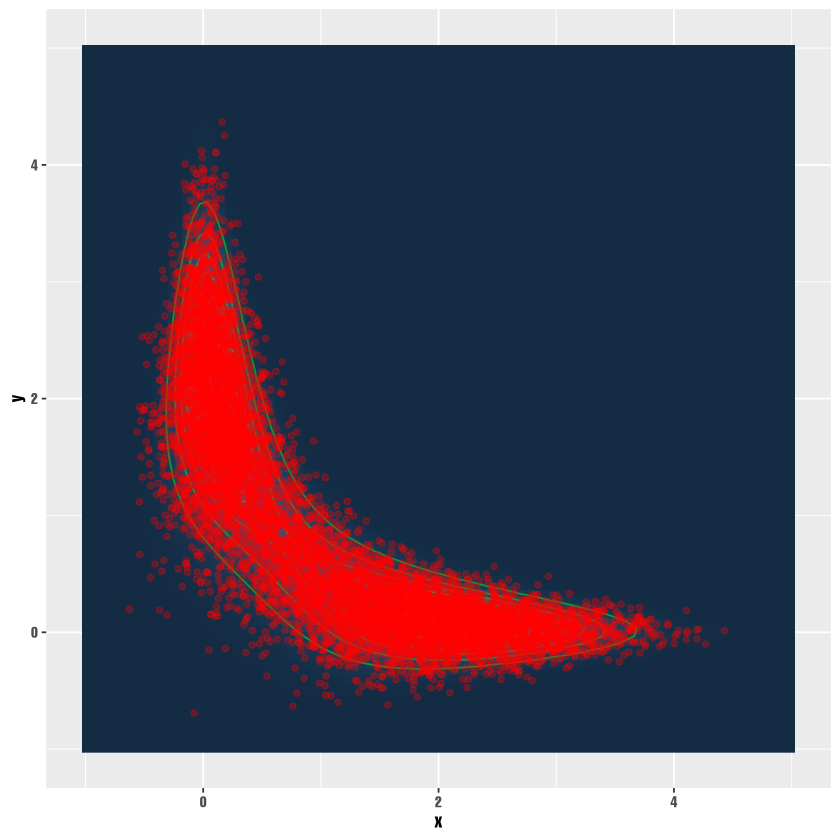

In [5]:
set.seed(8675309)
# a function to evaluate the gradient of a surface numerically:
gradient = function(f,x,h=1e-3){
    d = length(x)
    grad = rep(0,d)
    
    for (i in 1:d){
        xf = x
        xf[i] = x[i]+.5*h
        xb = x
        xb[i] = x[i]-.5*h        
        ff = f(xf)
        fb = f(xb)     
        grad[i] = (ff-fb)/h       
    }
    
    return(grad)    
}

leapfrog.integrator = function(x,p,U,L,M,eps=1e-1){
    for (i in 1:L){
        p = p - (eps/2)*gradient(U,x)
        x = x + eps*solve(M)%*%p
        p = p - (eps/2)*gradient(U,x)
    }
    
    return(c(x,p))
}

# implement HMC
HMC.sampler = function(nsamps,start,posterior,momentum.var,L=5){
    # args:
    # nsamps - number of sampler iterations
    # start - initial value of the sampler
    # posterior - density we want to sample from
    # momentum.var - the variance of the momentum sampling distribution  
    # L - number of timesteps to integrate the ODE 
    d = length(start)
    samps = matrix(start,nrow=nsamps,ncol=d,byrow=TRUE)
    U = function(x) {-log(posterior(x))}
    M = momentum.var*diag(d)
    
    for (i in 2:nsamps){
        theta_k = samps[i-1,]
        p_k = as.numeric(rmvnorm(1,rep(0,d),M))
        cand = leapfrog.integrator(theta_k,p_k,U,L,M)       
        theta_star = cand[1:d]
        p_star = -1*cand[-(1:d)]

        H_star = -log(posterior(theta_star)) + .5*p_star%*%solve(M)%*%p_star 
        H_k = -log(posterior(theta_k)) + .5*p_k%*%solve(M)%*%p_k        
        alpha = exp(-H_star + H_k )

        u = runif(1)      
        if (u<alpha){
            samps[i,] = theta_star
        }
        
        else {
            samps[i,] = theta_k
        }
    }
    
    return(data.frame('x'=samps[,1],'y'=samps[,2]))
}  


hmc.samps = HMC.sampler(nsamps, start, f, 1, L=10)

# 2-D traceplot
p + geom_point(data=hmc.samps,aes(x=x,y=y,z=''),color='red',alpha=.3) 

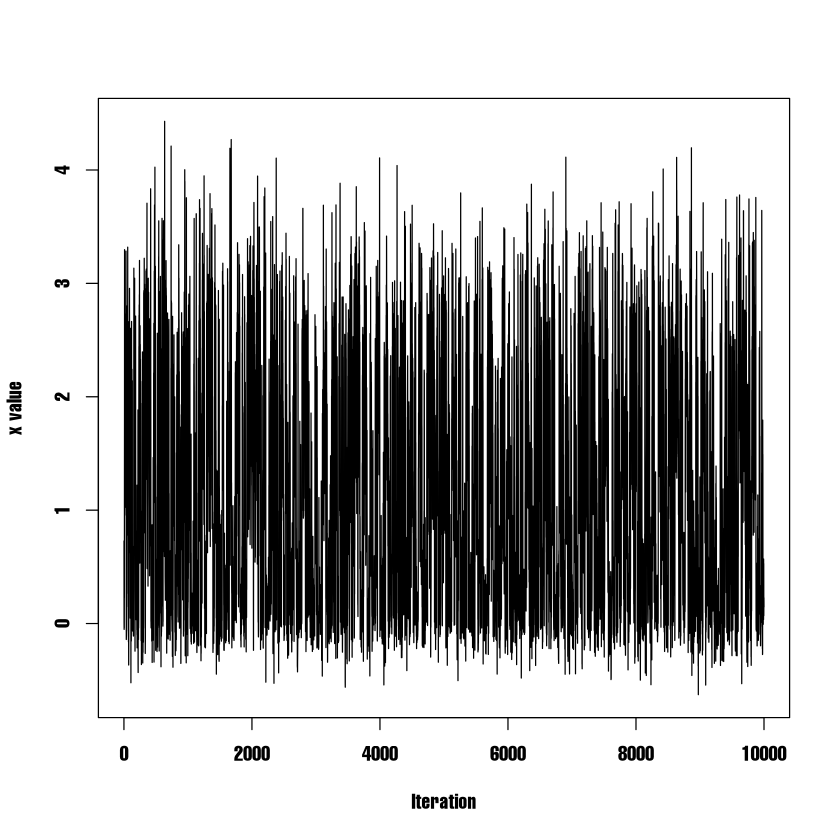

In [6]:
# 1-D traceplot
plot(hmc.samps$x,type='l',xlab='Iteration',ylab='x value') # 1-D traceplot

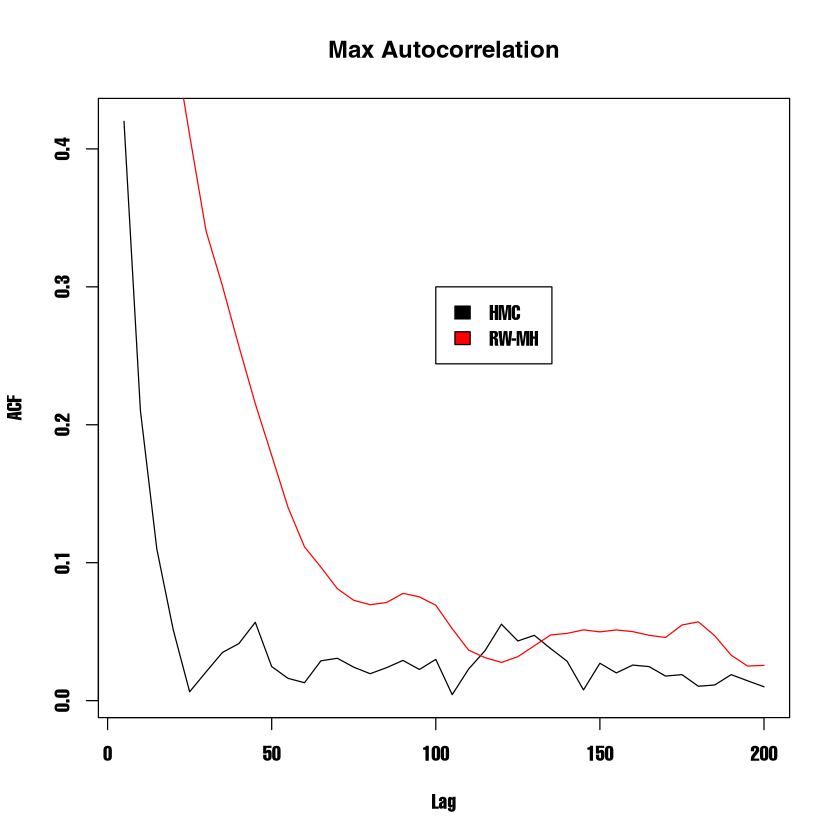

In [7]:
# plot autocorrelation (maxed across x and y)
hmc.acf = apply(autocorr.diag(mcmc(hmc.samps),lags=lags), 1, function(x){max(abs(x))})
plot(lags, hmc.acf, type='l', xlab='Lag', ylab='ACF', main='Max Autocorrelation')
lines(lags,mh.acf,col='red')
legend(100,.3,c('HMC','RW-MH'),c('black','red'))

### Why is HMC more efficient than RW-MH?
I said before that the basic problem with RW-MH is that it's not adaptive, but this isn't the only reason. Even if we update the proposal covariance matrix to match the structure of the posterior, ultimately RW-MH is just a random walk. It's just as likely to double back on itself as it is to move away from its starting point. Because of this, it can waste a lot of time "retracing its steps", it doesn't spread out very fast. On the other hand, the Hamiltonian ODE tends to produce very "exploratory" transitions: its proposals tend to be both far away from its starting point, but also remain in regions of high probabilty density. Let's compare the initial behavior of the two algorithms: 

Warning message:
“Ignoring unknown aesthetics: z”
Warning message:
“Ignoring unknown aesthetics: z”


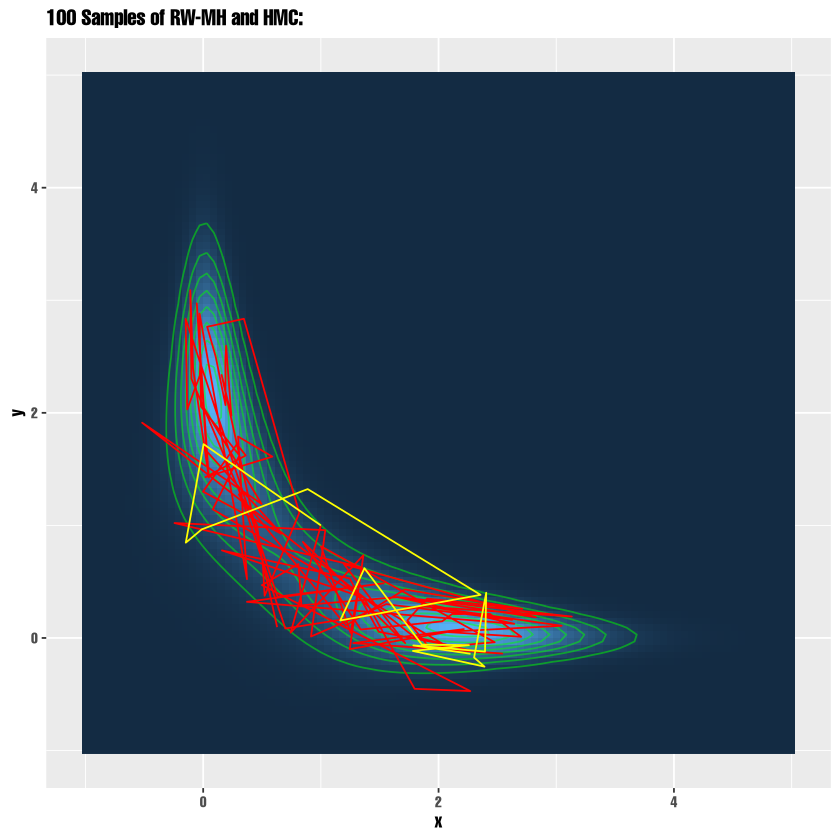

In [8]:
set.seed(8675309)

mh.samps = RWMH.sampler(100, c(1,1), f, diag(2))
hmc.samps = HMC.sampler(100, c(1,1), f, 1,L=10)

p + geom_path(data=hmc.samps,aes(x=x,y=y,z=''),color='red',alpha=1) +
    geom_path(data=mh.samps,aes(x=x,y=y,z=''),color='yellow',alpha=1) +
    labs(title="100 Samples of RW-MH and HMC:")

### Wow this algorithm is really `NUTS`!
This intuition, that we want an algorithm which doesn't "double-back" on itself, is the key observation behind an important variant of HMC: the "No U-Turn Sampler" (`NUTS`). `NUTS` dynamically chooses the integration time-period $L$ such that the proposal trajectory never doubles-back, hence "No U-Turn". `NUTS` is acutually the version of HMC implemented in `Stan` (plus some further performance tweaks). The specifics of this algorithm are beyond the scope of this lecture, but you can find more information on it [here](http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf).

## `Stan` Workflow
Now that we've got the broad picture of how HMC works, let's turn back to `Stan`. `Stan` is a compiled language. Unlike `R` or `Python`, a `Stan` script must be passed through a compiler before it can be executed. While it is possible to use `Stan` completely by itself in this way, it's much easier to use a wrapper, such as the package `RStan`. While we will still need to write our `Stan` model files separately, `Rstan` allows us to compile them, pass them data, and collect the sampling results entirely from within `R`.    
![alt text](imgs/workflow.png)

## Writing `Stan` Model Files
Today we're just going to cover the basics of writing a `Stan` model. `Stan` has a lot of functionality which I won't be able to cover here, so I encourage you to bookmark the [documentation](https://mc-stan.org/users/documentation/); it's very thorough and easy to read/search through.

`Stan` model files must adhere to a very specific structure. Each file is organized into a sequence of named blocks, whose bodies contain *declarations* or *statements*. These blocks are:

`
functions {
  // Define any custom functions
}
data {
  // Declare all data to be used in the model
}
transformed data {
   // Perform any manipulations on the data
}
parameters {
   // Declare model parameters
}
transformed parameters {
   // Perform any manipulations on model parameters 
}
model {
   // State model priors and likelihood
}
generated quantities {
   // Define any additional quantities you want to sample  
}
`

All program blocks are optional, however the order matters: `data` must come before `model`. Any function or variable defined in a block is available in any *later* block, but not earlier.

## Example 1: Genetic Linkage Model
Let's look at how we could perform inference on the genetic linkage model from the homework. Recall that this model says that animals are distributed into four categories: $Y=(y_1,y_2,y_3,y_4)$, where the probabilities of an animal belonging to any category is given as $(\frac{2+\theta}{4},\frac{1-\theta}{4},\frac{1-\theta}{4},\frac{\theta}{4})$. Furthermore assume we have the data $Y=(125,18,20,34)$.

Let's first define our `Stan` model:

In [9]:
stan.mod = "
data {
  int Y[4]; // declare the data (we'll pass this later from RStan) 
}

parameters {
  real<lower=0,upper=1> theta; // declare the model parameters
}

transformed parameters {
  vector<lower=0,upper=1>[4] p; // we need to transform the parameters before passing them to the model 

  p[1] = (2+theta)/4;
  p[2] = (1-theta)/4;
  p[3] = (1-theta)/4;
  p[4] = theta/4;
}

model {
  theta ~ beta(1,1); // uniform prior

  Y ~ multinomial(p); // multinomial likelihood
}

"

Some comments on this code. First, `Stan` is statically typed. Each variable needs to be declared before we can assign values to it, and furthermore they type of this variable cannot change throughout the code (in constrast in `R` where might say `x=2` followed by `x='a'` without issue). The declaration of each variable can also be used to assert *bounds* on the variable's value. If you know for sure that a variable must be positive, bounded in $[0,1]$, etc. then you should include that information in the declaration. Furthemore, observe that we only declare the variables in the `data` block, we never hardcode the data values into the `Stan` model file. Instead, we'll pass them to `Stan` through the `RStan` package. Let's see how we do this now:

In [10]:
library(rstan)

Y=c(125,18,20,34)

nsamps = 1e4
chains = 4
seed = 8675309

stan.dat = list('Y'=Y)

# NORMALLY:
#fit = stan("MODEL_FILE.STAN",
#           data=stan.dat,
#           chains=chains,
#           iter=nsamps,
#           seed=seed)

# FOR ILLUSTRATION PURPOSES:
fit = stan(model_code = stan.mod,
           data=stan.dat,
           chains=chains,
           iter=nsamps,
           seed=seed)

Loading required package: StanHeaders

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following object is masked from ‘package:coda’:

    traceplot





SAMPLING FOR MODEL '91d0e21a7da70e0ab26c9acbd3e6dae3' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.055721 seconds (Warm-up)
Chain 1:                0.056282 seconds (

In [11]:
library(bayesplot)
print('Gelman-Rubin Diagnostic is:')
rhat(fit,pars='theta')

This is bayesplot version 1.7.1

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting



[1] "Gelman-Rubin Diagnostic is:"


[1] 1.000016

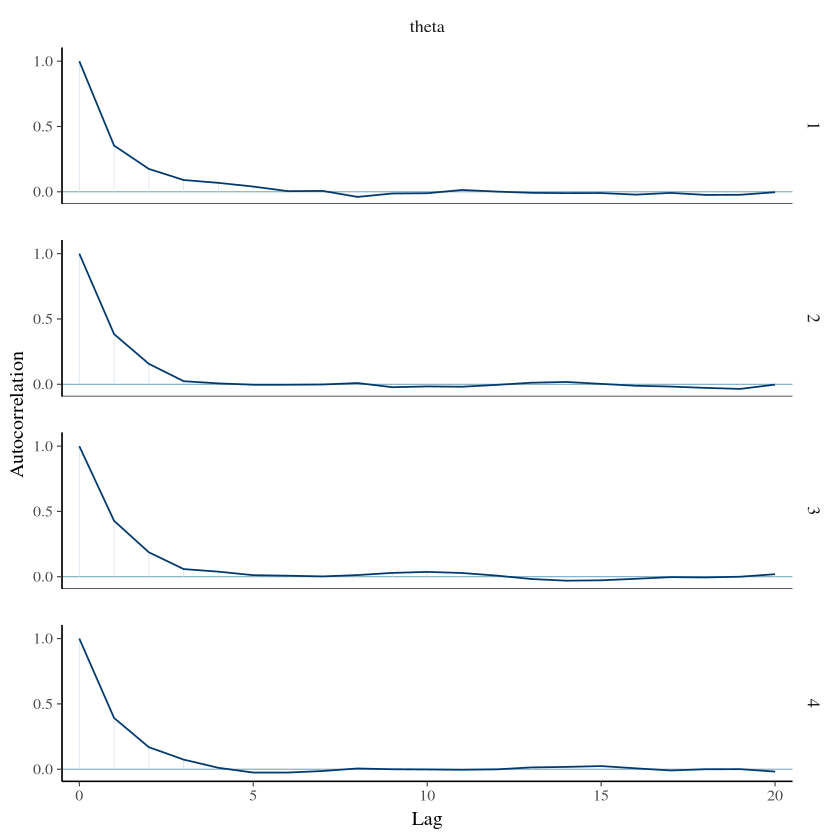

In [12]:
mcmc_acf(as.array(fit),pars='theta')

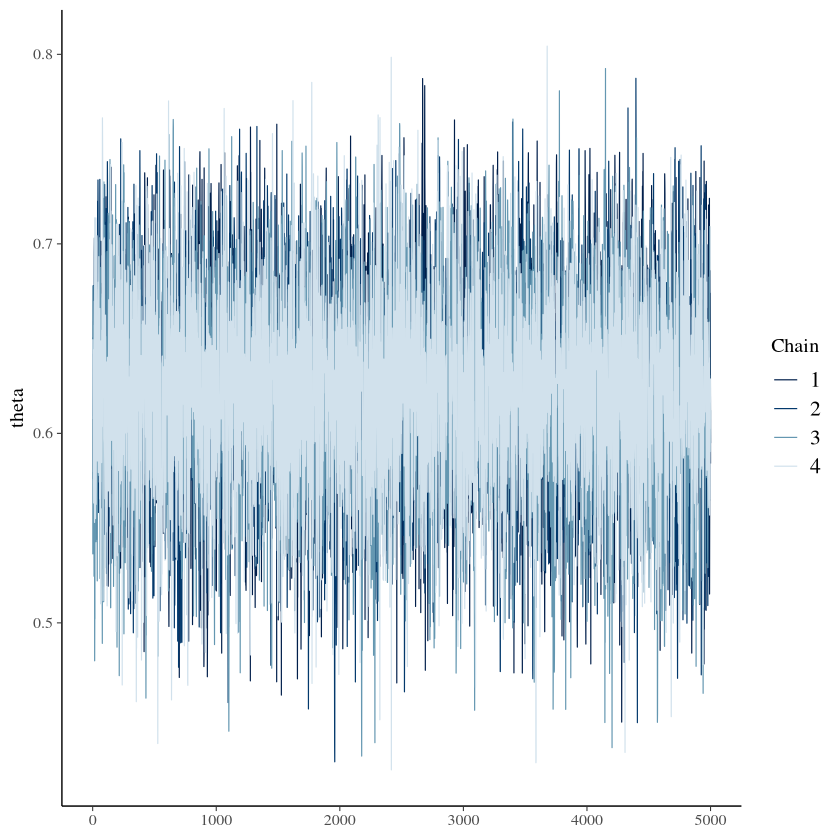

In [13]:
mcmc_trace(as.array(fit),pars='theta')

the following parameters were dropped because they are duplicative
p[3]



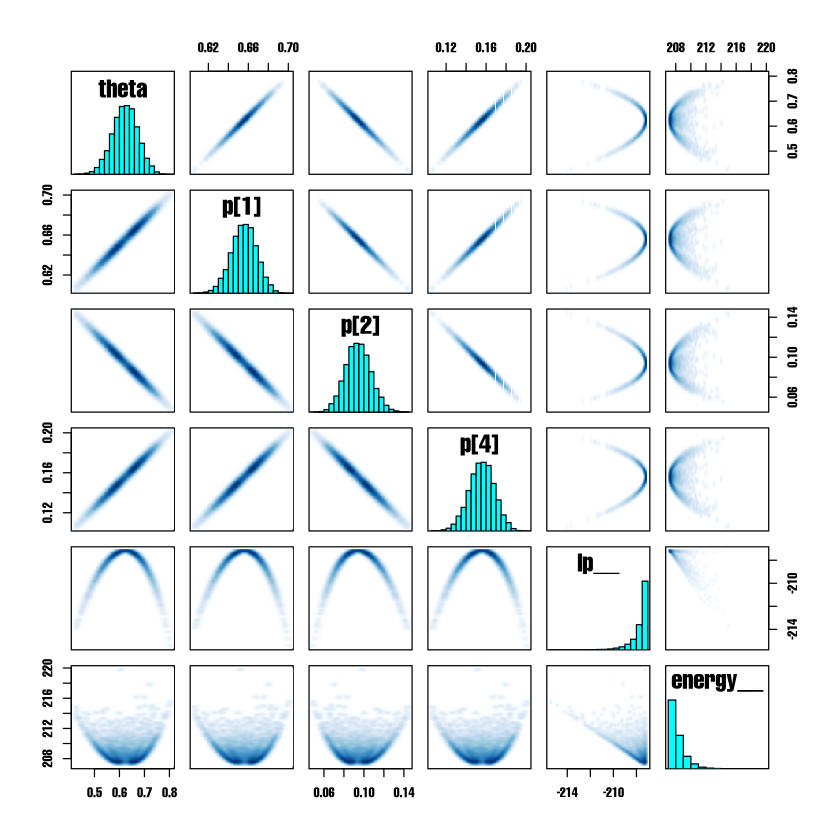

In [14]:
pairs(fit)

### Thinning
A word on thinning: you can pre-specify the thinning parameter in the `stan` function it will apply the thinning directly during sampling. However, per the `RStan` documentation:
> The default \[of the thinning argument\] is 1, which  is  usually  the  recommended  value.   Unless  your  posterior  distribution takes up too much memory we do not recommend thinning as it throws away information.  The tradition of thinning when running MCMC stems primarily from the use of samplers that require a large number of iterations to achieve the desired effective sample size. Because of the efficiency (effective samples per second) of Hamiltonian Monte Carlo, rarely should this be necessary when using Stan

## Example 2: Covariate Selection with `LOO`
For our final example today, we're going to look at logistic regression in `Stan`, but with a slighty twist: we'll also perform some basic variable selection. As an example, let's look at a dataset of [speed-dating outcomes](https://github.com/keithmcnulty/speed_dating). This consists of a series of binary observations $y_i \in \{0,1\}$ (indicating whether the respondent felt like their partner was a match or not), as well as a vector of covariates representing either how "fun" the partner was perceived by the respondent, or how "smart" they appeared. We'd like to figure out whether "smartness" or "fun-ness" better predicted a match.

One way to choose between these two models is by performing Leave-One-Out Cross-Validation (LOO-CV). To do so, we fit the model to all of the data points except one, and then see how well the model predicts the excluded data point. By repeating this procedure across all possible exclusions and averaging its performance, we get the LOO-CV score. The Bayesian version of this procedure estimates: 
Expected Log-Predicted Density:
$$
\text{elpd}_{\text{loo}} \approx \frac{1}{n} \sum_i P[y_i|y_{-i},X] 
$$
Here $y_{-i}$ are all the data points except data at index $i$, and $P[y_i|y_{-i},X]$ is the posterior predictive density (PPD) of the remaining data point. As we've already discussed, one could use importance sampling to quickly estimate these PPDs using only samples we've already obtained from the full posterior density. The package [`loo`](https://mc-stan.org/loo/) implements a (modified) version of this procedure for `stanfit` objects, giving us the `elpd` with little extra effort on our part. Let's use this package to choose between the $w_i$ and $z_i$:

In [47]:
set.seed(8675309)

# define model
logit.mod = "
data {
  int N; // number of data points   
  int<lower=0,upper=1> y[N]; // observations
  vector[N] x; // covariates
}

parameters {
  real a0;
  real a1;
}

model {
  a0 ~ normal(0,3);
  a1 ~ normal(0,3);

  y ~ binomial_logit(1, a0 + a1*x);
}

generated quantities{
  vector[N] log_lik;
  for (n in 1:N){
    log_lik[n] = bernoulli_logit_lpmf(y[n]|a0+a1*x[n]); 
    // this is going to be required to compute the LOO-CV 
  }
}

"

dat = read.csv('data/speed_date.csv') # read in data
dat = dat[complete.cases(dat),] # filter out incomplete cases
dat = dat[sample(1:nrow(dat),500),] # there's over 8K observations in the original dataset, we'll just use 500 

normalize = function(x){
    x = x-mean(x)
    x = x/sd(x)
    return(x)
}

stan.dat.fun = list('N'=nrow(dat),'y'=dat$dec,'x'=normalize(dat$fun))
stan.dat.intel = list('N'=nrow(dat),'y'=dat$dec,'x'=normalize(dat$intel))

fit.fun = stan(model_code = logit.mod,
           data=stan.dat.fun,
           chains=chains,
           iter=nsamps,
           seed=seed)

fit.intel = stan(model_code = logit.mod,
           data=stan.dat.intel,
           chains=chains,
           iter=nsamps,
           seed=seed)


SAMPLING FOR MODEL 'e045b72cabbb887601ebd12a4ec7fb0e' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 9.9e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.99 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 2.38833 seconds (Warm-up)
Chain 1:                2.30393 seconds 

In [48]:
# compare LOO-CV
library(loo)

ll.fun = extract_log_lik(fit.fun)
ll.intel = extract_log_lik(fit.intel)

print('LOO-CV comparison:')
loo_compare(loo(ll.fun), loo(ll.intel))

[1] "LOO-CV comparison:"


Warning message:
“Relative effective sample sizes ('r_eff' argument) not specified.
For models fit with MCMC, the reported PSIS effective sample sizes and 
MCSE estimates will be over-optimistic.”
Warning message:
“Relative effective sample sizes ('r_eff' argument) not specified.
For models fit with MCMC, the reported PSIS effective sample sizes and 
MCSE estimates will be over-optimistic.”


,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
model1,0.00000,0.000000,-297.6692,9.228554,2.021715,0.1621774,595.3385,18.45711
model2,-30.28938,7.526197,-327.9586,6.202949,2.003823,0.1193307,655.9172,12.40590


`loo` outputs a number of quantities, such as `elpd_loo` and its associated standard error (`SE`). `elpd` is scaled such that higher values (corresponding to higher posterior predictive density) indicates better model performance. We see that covariate $x_1$ is preferred.   

Now, writing the model file was a little bit more work than we would like to normally do, particularly since the base `R` function `glm` is so convenient. Fortunately the `rstanarm` package exists, which allows us to use `R`-style regression syntax with pre-compiled `Stan` model files for popular regression models:

In [45]:
fit.fun = stan_glm(formula = dec ~ normalize(fun),
    data = dat,
    family = binomial(link = "logit"),
    prior = normal(0, 3, autoscale = TRUE),
    prior_intercept = normal(0, 3, autoscale = TRUE),
    seed = 8675309
)

fit.int = stan_glm(formula = dec ~ normalize(intel),
    data = dat,
    family = binomial(link = "logit"),
    prior = normal(0, 3, autoscale = TRUE),
    prior_intercept = normal(0, 3, autoscale = TRUE),
    seed = 8675309
)
loo_compare(loo(fit.fun),loo(fit.int))


SAMPLING FOR MODEL 'bernoulli' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000122 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.22 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.209207 seconds (Warm-up)
Chain 1:                0.197868 seconds (Sampling)
Chain 1:              

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
fit.fun,0.00000,0.000000,-297.7252,9.219714,2.077879,0.1664155,595.4503,18.43943
fit.int,-30.18341,7.523042,-327.9086,6.220548,1.953550,0.1172424,655.8171,12.44110
